In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import urllib.request
from IPython.core.display import HTML

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

# One-dimensional, non-linear shallow-water equations
v1.73, 16 March 2018, by Brian Fiedler

reviewed September 2023


In the following sentence, note the two different meanings of "dimensional" ... in one sentence!  This is because of an historical accident about the use of the word "dimension".  If I were more knowledgeable, perhaps I could tell you whether languages other than English suffer from this confusion.  Oh well...

We consider these *dimensional* one-*dimensional* shallow-water equations:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x}= - g\frac{\partial h}{\partial x}
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x}
$$

The boundary conditions for $u(x,t)$ and $h(x,t)$ are:
$$
u(0,t)=0 \qquad u(L,t)=0
$$

$$
\frac{\partial h}{\partial x}(0,t)=0 \qquad \frac{\partial h}{\partial x}(L,t)=0
$$


In order for these numerical simulations to have the widest possible applicability, we render the equations *dimensionless*.
In this way, the solutions can be applied to a domain of any width $L$, any average depth $H$ and any acceleration due to gravity $g$.  So we don't use meters as the units of length, or seconds as the units of time. Instead, the horizontal unit of length is $L$, and the vertical unit of length is the average depth $H$, the unit of speed is $c\equiv\sqrt{gH}$, and the unit of time is $L/c$. So the *dimensional* variables in our original PDEs can be written as *dimensionless* numbers, denoted with a $^*$, multiply the natural length, time and velocity scales of the configuration.

$$
x \equiv x^* L  \qquad h \equiv h^* H \qquad u \equiv u^* c \qquad t \equiv t^* \frac{L}{c}
$$

Substitute the above definitions into the above PDEs and you will get some equations with a blizzard of $^*$. 
But look carefully, $g$ is gone:


$$
\frac{\partial u^*}{\partial t^*} + u^* \frac{\partial u^*}{\partial x^*}= - \frac{\partial h^*}{\partial x^*}
$$

$$
\frac{\partial h^*}{\partial t^*} = - \frac{\partial (u^*h^*) }{\partial x^*}
$$



Now drop  the $^*$ , and assume the $^*$ (the indicator of dimensionless) is **implied**:  

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x}= - \frac{\partial h}{\partial x}
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x}
$$

The dimensionless boundary conditions for $u(x,t)$ and $h(x,t)$ are:
$$
u(0,t)=0 \qquad u(1,t)=0
$$

$$
\frac{\partial h}{\partial x}(0,t)=0 \qquad \frac{\partial h}{\partial x}(1,t)=0
$$

Also, consistent with using $H$ as the average dimensional depth, we should initialize with $\int_0^1 h~dx = 1$ 

Also, to examine the properties of pure advection in the model, we slosh around a *passive scalar* $b$ in the model with $\frac{db}{dt}=0$

In [3]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")

In [4]:
def advect(u,b,dx,order):
# Assumes u=0 at end points (a solid boundary). So no need to calculate
# dbdx[0] and dbdx[-1]
    dbdx=np.zeros(len(b))
    
    if order == 2: # 2nd-order centered scheme
        dbdx[1:-1] =  (-b[0:-2] + b[2:])/(2*dx)

    elif order == 1: # 1st order upwind
        dbdx[1:-1] = np.where( u[1:-1]>0.,
                              -b[0:-2] + b[1:-1] 
                              ,        - b[1:-1] + b[2:] 
                              )/dx
        
    elif order == 3: # 3rd order upwind. But 1st order one point from boundaries  
        dbdx[1] = np.where( u[1]>0.,
                              -b[0] + b[1] 
                              ,     - b[1] + b[2] 
                              )/dx
        dbdx[-2] = np.where( u[-2]>0.,
                              -b[-3] + b[-2] 
                              ,      - b[-2] + b[-1] 
                              )/dx
        dbdx[2:-2] = np.where( u[2:-2]>0., 
                +   b[:-4]  - 6*b[1:-3] + 3*b[2:-2] + 2*b[3:-1] ,
                            - 2*b[1:-3] - 3*b[2:-2] + 6*b[3:-1] - b[4:] 
                               )/(6*dx)
    else:
        print("no advection scheme for",order)
        
    return -u*dbdx

In [5]:
def convergence(u,h,dx,order):
# Calculate convergence of a quantity d(u*h)/dx.
# Because h is staggered from u (in between u), we must
# interpolate and extrapolate h to the u grid so that
# u*h can be calculated.
# Note len(h) = len(u)+1
    assert len(h)==len(u)-1, 'h must be staggered from u'
    
    hu=np.zeros(len(u)) # will be h on the u-grid
    
    if order==3: # not really needed, does not have much effect, not recommended
        hum = hu.copy() # for 3rd order upwind interpolation, for u>o
        hup = hu.copy() # for 3rd order upwind interpolation, for u<0
        hum[2:-1] = ( 2*h[2:] + 5*h[1:-1] - h[:-2] ) / 6. 
        hup[1:-2] = ( 2*h[0:-2] + 5*h[1:-1] - h[2:] ) / 6. 
        hu[1:-1]= np.where( u[1:-1]>0., hum[1:-1], hup[1:-1] )
    else:
        hu[1:-1] = .5*( h[:-1] + h[1:] ) # centered interpolation of h to the u grid
        
    hu[0]  = h[0];   hu[-1] = h[-1] # extrapolate h to the u grid
    
    hflux = hu*u
    
    return (hflux[:-1]-hflux[1:])/dx

In [6]:
# RESTART HERE IF YOU WANT TO CHANGE THE GRID SIZE
# make the grid
N = 401 # number of x grid points for u (odd number is best?)
xmax = 1. # 0 <= x <= xmax
dx=xmax/(N-1.) # grid width
xu = np.linspace(0,xmax,N) # grid for u
xp = .5*( xu[:-1] + xu[1:] ) # staggered grid for h, and pressure
print(len(xu),len(xp),dx)

401 400 0.0025


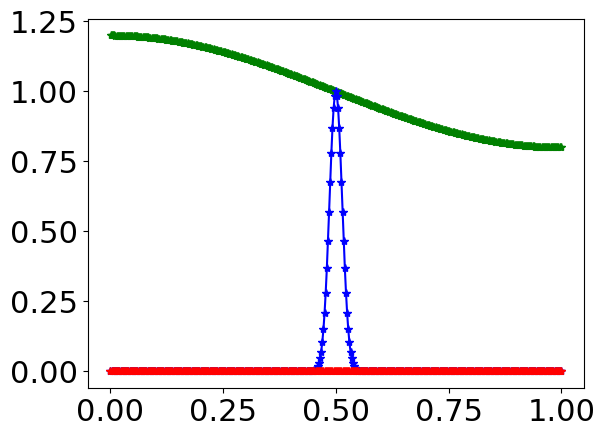

In [7]:
# initialize u, b, h
waveamp = 0.2 # amplitude of initial wave
xc = xmax/2. # center of domain
gwidth = .02 # Gaussian width
bi = np.exp( -((xu-xc)/gwidth)**2 )  # Gaussian for initial field of passive scalar b

# uncomment pairs of ui and hi:

ui = 0.*xu
hi = 1. + waveamp*np.cos(np.pi*xp/xmax) # note that h is on the pressure grid

#ui = waveamp*np.exp( -((xu-xc)/gwidth)**2 ) # also try 0.*waveamp or -1*waveamp
#hi = .9 + waveamp*np.exp( -((xp-xc)/gwidth)**2 ) 

plt.plot(xp,hi,'g*-')
plt.plot(xu,bi,'b*-')
plt.plot(xu,ui,'r*-'); 

In [8]:
dgrid = 0.2 # fraction of a grid space a wave is allowed to travel in one time unit
dt = dgrid*dx/1.0 # time-step (note wave speed is 1.0 in dimensionless model)
print("time-step dt selected to be:",dt)

tstop = 4. # stop when t>tstop
dplot = .1 # time increment between plots
aborder = 3 # Adams-Bashforth order: 1, 2 or 3
advord = 3 # advection order: 1, 2 or 3
conord = 2 # convergence order: 2 or 3
expt = '%d,%d,%d,%3.2f,%d' % (aborder, advord, conord, dgrid, N)
print(expt)

time-step dt selected to be: 0.0005
3,3,2,0.20,401


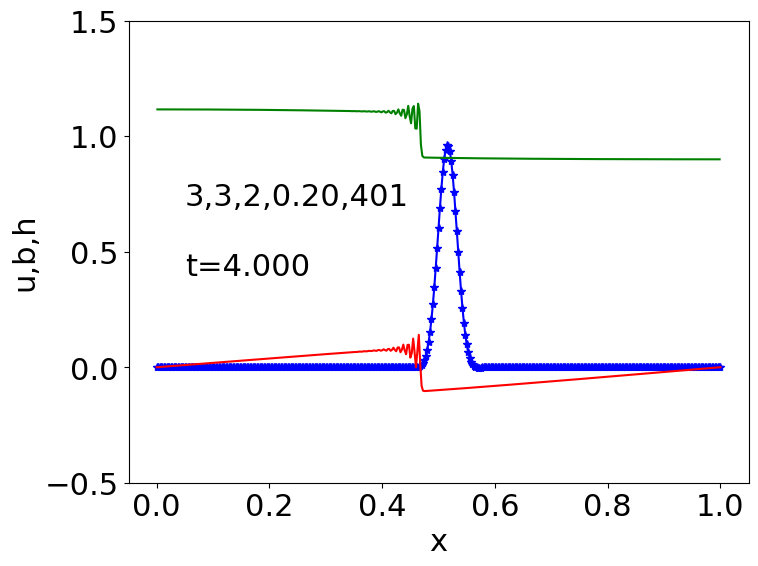

In [9]:
u = ui.copy()
b = bi.copy()
h = hi.copy()
dudt = 0.*u
dbdt = 0.*b
dhdt = 0.*h
dbdta = [0.,0.,0.] # items will be arrays of dbdt for Adams-Bashforth
dhdta = [0.,0.,0.] # for h...
dudta = [0.,0.,0.] # for u ....
nstep = 0 # counter for stepping
   
t = 0. # initial value for t    
tplot = 0. # time t for next plot

f, ax = plt.subplots(figsize=(8,6))
display(f)

vstore1 = [] # for storing a time series of a value of something in the simulation
vstore2 = [] # for storing a time series of a value of something in the simulation
tstore = [] # for storing the corresponding time of the value

while t < tstop + dt/2.:
    vstore1.append( h.mean() ) # if volume is conserved, h.mean() should be invariant
    vstore2.append( max(abs(h[:-1]-h[1:])/dx) )  # this is the max of abs(dhdx)
    tstore.append(t)
    nstep += 1
    abnow = min(nstep,aborder)
    if tplot-dt/2. < t <tplot+dt/2.: #plot
        Time.sleep(1./5.)
        ax.clear()
        ax.plot(xu,b,'b-*')
        ax.plot(xu,u,'r')
        ax.plot(xp,h,'g')
        ax.text(.05,.7,expt,fontsize=22)
        ax.text(.05,.4,'t={0:5.3f}'.format(t),fontsize=22)
        clear_output(wait=True)
        ax.set_xlabel('x')
        ax.set_ylabel('u,b,h',rotation=90)
        ax.set_ylim((-.5,1.5))
        display(f)
        tplot = min(tstop,t + dplot)
        if t < dt/2.: Time.sleep(2.)
        if t >= tstop: break
       
    dbdt = advect(u,b,dx,advord)
    
    dhdt = convergence(u,h,dx,conord) # to turn off non-linear: use h*0.+1
    
    dudt[1:-1] = (h[:-1]-h[1:])/dx # acceleration caused by slope of h       
    dudt += advect(u,u,dx,advord) # add non-linear advection term to acceleration
    
    # Adams-Bashforth time-step:
    dbdta = [dbdt.copy()] + dbdta[:-1]
    dudta = [dudt.copy()] + dudta[:-1]
    dhdta = [dhdt.copy()] + dhdta[:-1]
    b += dt*ab_blend(dbdta,abnow)
    u += dt*ab_blend(dudta,abnow)
    h += dt*ab_blend(dhdta,abnow)
    t = t + dt
    
    assert u.max()<2.e10, 'kaboom!'
       
plt.close() 

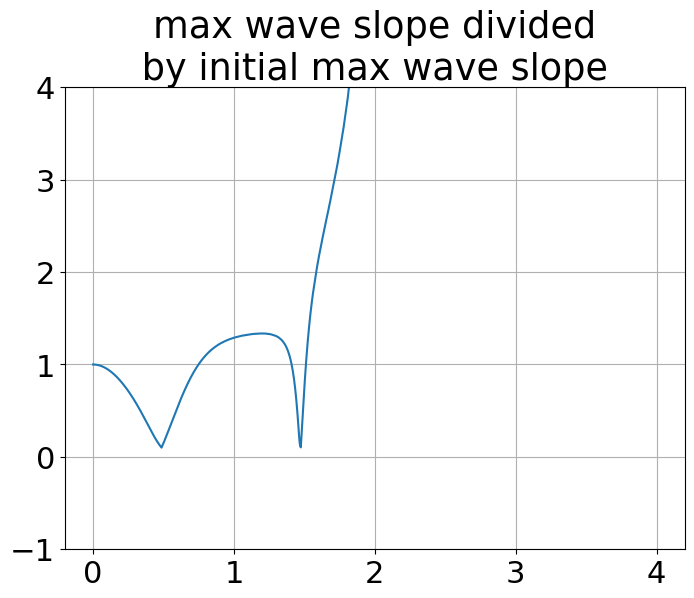

In [10]:
fig2,ax2 = plt.subplots(figsize=(8,6))
ax2.plot(tstore,vstore2/vstore2[0])
ax2.set_ylim((-1,4))
ax2.set_title("max wave slope divided\n by initial max wave slope ")
ax2.grid()

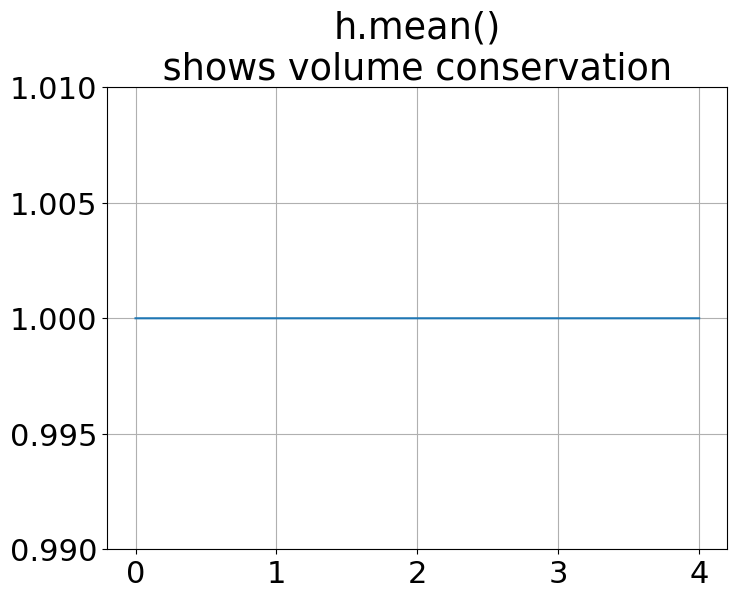

In [11]:
fig1,ax1 = plt.subplots(figsize=(8,6))
ax1.plot(tstore,vstore1)
ax1.set_ylim((.99,1.01))
ax1.set_title("h.mean()\n shows volume conservation ")
ax1.grid()

# Student Tasks

## 1. Try your hand at LaTeX typesetting

Suppose a water wave is approximated as hydrostatic.  This means

$$
\frac{\partial p}{\partial z} = -g \rho
$$

is a good approximation for what is happening below the surface, which is at $z=h(x,t)$.

As always in shallow-water theory, assume the pressure just above the surface is
a constant.  This constant pressure could be the atmospheric pressure of the lab, denoted $p_a$. Of course, being meteorologists, we know $p_a$ is not constant and varies slightly from floor to ceiling. But including that fact would modify the predictions of the theory ever so slightly, at the expense of being much more complicated.

Derive, in $\LaTeX$, that below the surface:

$$
\frac{1}{\rho} \frac{\partial p}{\partial x} =  g\frac{\partial h}{\partial x}
$$

## 2. Properties of the linear solution

Here are the dimensional nonlinear equations:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x}= - g\frac{\partial h}{\partial x}
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x}
$$

If $h$ remains very close to $H$ with $h(x,t)=H+\eta(x,t)$, and $u$ and $\eta$ are very small value, these linear equations should apply:
$$
\frac{\partial u}{\partial t} = - g \frac{\partial \eta}{\partial x}
$$

$$
\frac{\partial \eta}{\partial t} = - H \frac{\partial u }{\partial x}
$$

Show that $ \eta(x,t) = A \cos(k x) \cos(\omega t) $ is a solution of the above linear equations.


1. How is the frequency $\omega$ related to $k$, $g$ and $H$?
1. For what values of $k$ are the boundary conditions at $x=0$ and $x=L$ are satisfied?
1. Find $u(x,t)$ that is consistent with the above $\eta(x,t)$.
1. Find the *period* $\tau$ of the solution. ($\tau = 2\pi/\omega$) Play with a small-amplitude wave, for example `waveamp=0.02`.  Do you observe this linear property for wave period?  (The dimensionless model equations are equivalent to taking $g=1$ and $H=1$ and $L=1$.)

Here is a bonus exercise for you. The phase speed of the dimensionless waves is $c=1$. If we had a domain infinite in the x-direction, then we need not be concerned about boundary conditions.  The is a very simple solution for
a rightward traveling wave: $\eta(x,t)=f(x-t)$ and $u(x,t)=f(x-t)$.  For a leftward traveling wave, the solution is $\eta(x,t)=g(x+t)$ and $u(x,t)=-g(x+t)$.  This works for any functions $f$ and $g$, and both waves can exist together. Uncomment
`hi = .9 + waveamp*np.exp( -((xp-xc)/gwidth)**2 )` to see such a wave.

## 3. Study of non-linear steepening

Conduct a study of non-linear steepening.  Let's label the dimensionless time for $\frac{\partial h}{\partial x}$ to double as $t_2^*$.

Specifically, conduct experiments to show how $t_2^*$ varies with `waveamp`. 
Make a table and/or plot to show the results.

## 4. How to interpret this dimensionless model

Suppose you have two customers needing forecasts for a non-linear, one-dimensional, shallow-water wave. Lo and behold, for both cutomers the initial condition of the free surface is half a cosine function, just like in our standard case. Specifcially, they want to know how many *minutes* elapse before the maximum magnitude of slope $\partial h/ \partial x$ doubles from the initial magnitude. This means they want the **dimensional** time quantity $t_2 = t_2^*\frac{L}{c} $.

Here are the specs for the two customers:

1. On Mars, $g = 3.71~\mathrm{m}~\mathrm{s}^{-2}$. (equator, no Coriolis force). $H = 30~\mathrm{m}$, $L = 200~\mathrm{km}$,  initial sinusoidal wave amplitude $A_i = 0.15 H = 4.5~\mathrm{m}$.

1. On Earth, $g = 9.81~\mathrm{m}~\mathrm{s}^{-2}$. (equator, no Coriolis force). $H = 50~\mathrm{m}$, $L = 200~\mathrm{km}$,  initial sinusoidal wave amplitude $A_i = 0.15 H = 7.5~\mathrm{m}$.

Suppose the simulations are very expensive to run on a computer.  So you satisfy both customers forecast needs by running ONE simulation. 

What ONE simulation do you run? In fact, you may have already done it.  It may be in your answer for **3**.  Or maybe you can interpolate from the values you studied.

What is the single dimensionless forecast $t_2^*$ and the distinct dimensional forecasts $t_2$ for the two customers?

But the customers want some reassurance that your forecast is accurate.  So they convince you to double the resolution of the model and run the simulation again. Does your forecast for $t_2^*$ change?  Do other properties of the forecast change, such as the oscillations just behind the wave front?

## 5. Does the model conserve energy?

Conducting simulations with dimensionless model equations allows for very efficient exploration of the parameter space and for generalization of the results. 
However, IMHO, development of theorems about properties of the model is often easier with the dimensional equations. For one thing, you can recognize errors in your analysis if the terms become dimensionally inhomogeneous.  Also, it is easier to recognize that a term represents a physical quantity, such as gravitational potential energy, if we see the familiar $g$ in the equations.
For these reasons, we analyze the energy conservation properties of the model with the dimensional equations:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x}= - g\frac{\partial h}{\partial x}
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x}
$$

### Step one: energy in a parcel, per unit mass:
The momentum equation, with the product rule applied to the advection term:
$$
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x} \frac{u^2}{2}= -g\frac{\partial h}{\partial x}
$$

Multiplying by $u$:
$$
u\frac{\partial u}{\partial t} + u \frac{\partial}{\partial x} \frac{u^2}{2} = - u g\frac{\partial h}{\partial x}
$$

Prognostic eqution for $u^2/2$:
$$
\frac{\partial}{\partial t}\frac{u^2}{2} + u\frac{\partial}{\partial x} \frac{u^2}{2} = - u g\frac{\partial h}{\partial x}
$$


### Integrating over depth:
That's easy, the shallow-water equations are independent of $z$ so integrating over $z$ means multiplying by $h$:
$$
h\frac{\partial}{\partial t}\frac{u^2}{2} + hu\frac{\partial}{\partial x} \frac{u^2}{2} =- hu g\frac{\partial h}{\partial x}
$$

$$
h\frac{\partial}{\partial t}\frac{u^2}{2} + hu\frac{\partial}{\partial x}\left( \frac{u^2}{2} + gh \right)= 0
$$

The product rule is applied:
$$
h\frac{\partial}{\partial t}\frac{u^2}{2} +\frac{\partial}{\partial x}\left[ hu \left( \frac{u^2}{2} + gh \right)\right] + \left( \frac{u^2}{2} + gh \right)\frac{\partial(hu)}{\partial x} = 0
$$

### Using incompressibility:
$$
h\frac{\partial}{\partial t}\frac{u^2}{2} +
\frac{\partial}{\partial x}\left[ hu \left( \frac{u^2}{2} + gh \right)\right]
+ \left( \frac{u^2}{2} + gh \right)\frac{\partial h}{\partial t}
= 0
$$

$$
h\frac{\partial}{\partial t}\frac{u^2}{2} + \frac{u^2}{2}\frac{\partial h}{\partial t}
+ \frac{\partial }{\partial t}\frac{gh^2}{2}
= - \frac{\partial}{\partial x}\left[ hu \left( \frac{u^2}{2} + gh \right)\right]
$$
Using the product rule again:
$$
\frac{\partial}{\partial t}\left( h\frac{u^2}{2} + \frac{gh^2}{2} \right)
= - \frac{\partial}{\partial x}\left[ hu \left( \frac{u^2}{2} + gh \right)\right]
$$


### Integrating over the length:

$$
\int_0^L \frac{\partial}{\partial t}\left( h\frac{u^2}{2} + \frac{gh^2}{2} \right) dx
= - \int_0^L \frac{\partial}{\partial x}\left[ hu \left( \frac{u^2}{2} + gh \right)\right] dx
$$

The time derivative can be interchanged with the integral on the left, and the integral on the right is trivial.

$$
\frac{\partial}{\partial t} \int_0^L \left( h\frac{u^2}{2} + \frac{gh^2}{2} \right) dx
= - \left[ hu \left( \frac{u^2}{2} + gh \right)\right]_{x=0}^{x=L} = 0
$$

Equating to $0$ in the above because $u=0$ at both $x=0$ and $x=L$.

### The time-invariant quantity 

The model differential equations should conserve *total energy* (per mass):

$$
E = \int_0^L \left( h\frac{u^2}{2} + \frac{gh^2}{2} \right) dx
$$

You are welcome to multiply by $1/L$ to make the above integral an average over $x$, rather than the sum.

If you multiplied the integral by the constant $\rho$, could you recognize the terms in the integrand as
the kinetic energy per unit area and gravitational potential energy per unit area?

### Task: Is energy conserved in the model?

The dimensionless counterpart to total energy is:

$$
E = \int_0^1 \left( h\frac{u^2}{2} + \frac{h^2}{2} \right) dx
$$

I suggest you calculate $u^2/2$ in the *u-grid*, and interpolate that to the *p-grid*. Then put the
integrand into an array on the *p-grid*.
The integral is obtained with the `.mean()` method.
Store it in `vstore3`. Plot it as a function of time.  How well did the model comply with conservation of energy?
